# Volatility basket strategy

- Based on `15-vol-basked-strategy-1d` 
- Add position concentration risk reducer: `Parameters.max_concentration`

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "16-vol-basket-strategy-1d-max-allocation"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_1d

    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    
    # Alternative categories
    #categories = {"Artificial Intelligence (AI)"}
    #categories = {"Decentralized Finance (DeFi)"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    picks_at_the_start_of_month = 10  # At the start of the each month, decide which assets are tradeable each month
    max_assets_in_portfolio = 6  # How many assets our basket can hold once
    allocation = 0.99  # Allocate all cash to volatile pairs
    min_rebalance_trade_threshold_pct = 0.1  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 10  # Don't make buys less than this amount
    min_volatility_threshold = 0.040000  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.02  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.33 # How large % can one asset be in a portfolio once

    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()
    rebalance_volalitity_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()
    rolling_volume_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    min_volume = 1_000_000   # USD
    min_liquidity = 200_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 10, 20)
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import load_extra_metadata, filter_scams


#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
BENCHMARK_PAIRS = [
    (ChainId.ethereum, "uniswap-v3", "WBTC", "USDT", 0.0005),
    (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in BENCHMARK_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    pairs_df = deduplicate_pairs_by_volume(pairs_df)

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    print("Universe is (including benchmark pairs):")
    for idx, tpl in enumerate(pairs_df.iterrows()):
        pair_id, pair = tpl
        print(f"   {idx+1}. pair #{pair_id}: {pair.base_token_symbol} - {pair.quote_token_symbol} ({pair.exchange_slug}) - volume 24h: {pair.volume:,} USD")

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",  # USDC
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark tokens so they can be separated from the rest of the tokens
    # for the index construction
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 1000 tokens>
Total 51 pairs to trade on ethereum for categories {'Meme'}
After scam filter we have 43 pairs
Scammy pair TRUMP - WETH, risk score 0.0, pool 0x56bc8f3293f53825c9fbd6ddfe0cafefa82820d0, token 0x6aa56e1d98b3805921c170eb4b3fe7d4fda6d89b
Scammy pair DOG - WETH, risk score 20.0, pool 0x9b3423373e6e786c9ac367120533abe4ee398373, token 0xbaac2b4491727d78d2b78815144570b9f2fe8899
Scammy pair BabyDoge - WETH, risk score 0.0, pool 0x9f2ebe69a86c079f3d4c3b94a11932b676b72f74, token 0xac57de9c1a09fec648e93eb98875b212db0d460b
Scammy pair Bonk - WETH, risk score 20.0, pool 0x403b1b747b1efb309070436c9ac99bf476f299ea, token 0x1151cb3d861920e07a38e03eead12c32178567f6
Scammy pair PEOPLE - WETH, risk score 25.0, pool 0x83abecf7204d5afc1bea5df734f085f2535a9976, token 0x7a58c0be72be218b41c608b7fe7c5bb630736c71
Scammy pair Puff - WETH, risk score 25.0, pool 0x0275885d271c9e5ae7d4aa15ae6c1bcb7e5ae2b8, token 0x31b6100f5f4466e6daeb1edb2f2ce6e548cf8938
Sca

Data missing warning: We asked OHLCV data for 43 trading pairs, but only got for 43 pairs. This is usually because time period 2022-08-15 00:00:00 - 2024-10-20 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 43 pairs:   0%|          | 0/43 [00:00<?, ?it/s]

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 43 assets
Category trading pairs 41
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_business_month(close, window_length_bars, pair: TradingPairIdentifier, dependency_resolver) -> pd.Series:
    """Snap the trailing returns to business month start day/hour."""

    hour = 8  # 8AM

    def first_day_8am(group):
        target_time = group.index[0].floor('D') + pd.Timedelta(hours=hour)
        return group.loc[target_time] if target_time in group.index else np.NaN
        #return group.loc.get(target_time)

    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    

    # TODO: Clean up here?
    # Let's clear this up
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    ewm = trailing_sharpe.ewm(span=ann_factor/4).mean()  # Quaterly
    try:
        first_day_series = ewm.resample('MS').apply(first_day_8am)
    except IndexError as e:
        #  IndexError: index 0 is out of bounds for axis 0 with size 0
        print(f"trailing_sharpe_business_month(): Skipping {pair.get_ticker()} because of {e}")
        return pd.Series(dtype=float, index=pd.DatetimeIndex([]))

    # first_day_series.attrs["time_bucket"] = TimeBucket.d30  # Hint this is monthly data
    return first_day_series


def top_pairs_business_month(
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,    
) -> pd.Series:
    """Get the pairs that have the best trailing sharpe at the start of the month.
    
    - These are the pairs we will trade

    """

def available_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Get the available tradeable pairs on each date.

    - Pairs for which have business month trailing sharpe available
    
    - Because the trading universe is only expanding, this number is only going up

    :return:
        Series with pair count for each timestamp    
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month")
    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std


def rolling_cumulative_volume(volume: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=window_length_bars).sum()
    return rolling_volume


def rolling_liquidity_avg(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=window_length_bars).mean()
    return  rolling_liquidity_close

    
def volume_inclusion_criteria(   
    close: pd.Series, 
    min_volume: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
    pair: TradingPairIdentifier,    
) -> pd.Series:
    """Calculate pair inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    - For each month we pick the N pairs that have the best mohtly trailing sharpe 

    TODO: Add liquidity check later

    :return:
        Series that is True or False whether the pair meets inclusion criteria at any point of time
    """
    series = dependency_resolver.get_indicator_data(
        "rolling_cumulative_volume",
        pair=pair
    )
    mask = series >= min_volume

    # Need to match the DatetimeIndex of trailing_sharpe_business_month
    # for boolean array max() is the same sany()
    monthly_data = mask.resample('MS').max()
    # Because we sample each month month start, the pair is not availabe until the next month
    return monthly_data.shift(-1).fillna(0).astype(int)


def included_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Included pairs is a combination of available pairs and inclusion criteria.

    - At a given moment of time, which of all available pairs are truly tradeable

    - Pairs for which have business month trailing sharpe available
    
    - Pairs that meet the inclusion criteria

    :return:
        Series with pair count for each timestamp
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria")

    # Drop all False values (pair was not included)
    series = series.loc[series == True]

    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()
    

def monthly_traded_pairs(   
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """For each month, get the list of the pairs we will trade.
    
    - This series can be exploded and forward filled to get hourly boolean mask
    
    :return:
       Monthly Pandas series with (pair_id, timestamp) index that contains sharpe values only for top picks of that month.

       The value of the series is monthly trailing sharpe for the pair.
    """

    # Get trailing sharepe for all pairs as (pair_id, timestamp) indexed series
    df = pd.DataFrame({
        "trailing_sharpe_business_month": dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month"),
        "volume_inclusion_criteria": dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria"),
    })

    # Remove assets that are not part of the category,
    # and are only included for benchmark or currency conversion purposes
    df =  df[~df.index.get_level_values('pair_id').isin(benchmark_pair_ids)]
    
    # Drop pairs that do not meet volume inclusion criteria, and leave the sharpes left 
    # for the pairs that do meet the criteria
    df["filtered_sharpe"] = df["trailing_sharpe_business_month"].loc[df["volume_inclusion_criteria"] == True]

    top_picks = df["filtered_sharpe"].groupby('timestamp').nlargest(picks_at_the_start_of_month)
    
    # MultiIndex is now (timestamp, pair_id, timestamp) -> fix it
    top_picks = top_picks.droplevel(0)

    """
    pair_id  timestamp 
    36926    2022-08-01          NaN
    37316    2022-08-01          NaN
    52587    2022-08-01          NaN
    68900    2022-08-01          NaN
    36926    2022-09-01          NaN
    37316    2022-09-01          NaN
    52587    2022-09-01          NaN
    68900    2022-09-01          NaN
    2701164  2022-10-01     2.788998
    2711945  2022-10-01    -0.039353
    """
    
    return top_picks
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "rolling_cumulative_volume",
        rolling_cumulative_volume,
        {"window_length_bars": parameters.rolling_volume_bars},
        IndicatorSource.ohlcv,
    )    
    # TODO: Currently web API issues loading this data for certain pairs
    #
    # indicator_set.add(
    #     "rolling_liquidity_avg",
    #     rolling_liquidity_avg,
    #     {"window_length_bars": parameters.rolling_liquidity_bars,
    #     IndicatorSource.liquidity,
    # )        
    indicator_set.add(
        "trailing_sharpe_business_month",
        trailing_sharpe_business_month,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
        order=2,  # After trailing_sharpe
    )    
    indicator_set.add(
        "available_pairs",
        available_pairs,  
        {},  
        IndicatorSource.strategy_universe,
        order=3,  # After trailing_sharpe_business_month
    )       
    indicator_set.add(
        "volume_inclusion_criteria",
        volume_inclusion_criteria,  
        {"min_volume": parameters.min_volume},  
        IndicatorSource.ohlcv,
        order=3,  
    )       

    
    indicator_set.add(
        "included_pairs",
        included_pairs,  
        {},
        IndicatorSource.strategy_universe,
        order=4,  
    )       

    indicator_set.add(
        "monthly_traded_pairs",
        monthly_traded_pairs,  
        {
            "picks_at_the_start_of_month": parameters.picks_at_the_start_of_month,
        },  
        IndicatorSource.strategy_universe,
        order=5,  
    )       

    return indicator_set


indicators = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=create_indicators,
    parameters=parameters,
)

Reading cached indicators trailing_sharpe, volatility, rolling_cumulative_volume, trailing_sharpe_business_mon…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_43_2022-08-15-2024-10-20_ff


# Examine indicator and price data

- Manually inspect that our indicator data calcuations looks correct
- Display Sharpe et. al for example asset

In [6]:
selected_assets = ["PEPE", "MEME", "SHIB"]

Examine price development of the picked assets.

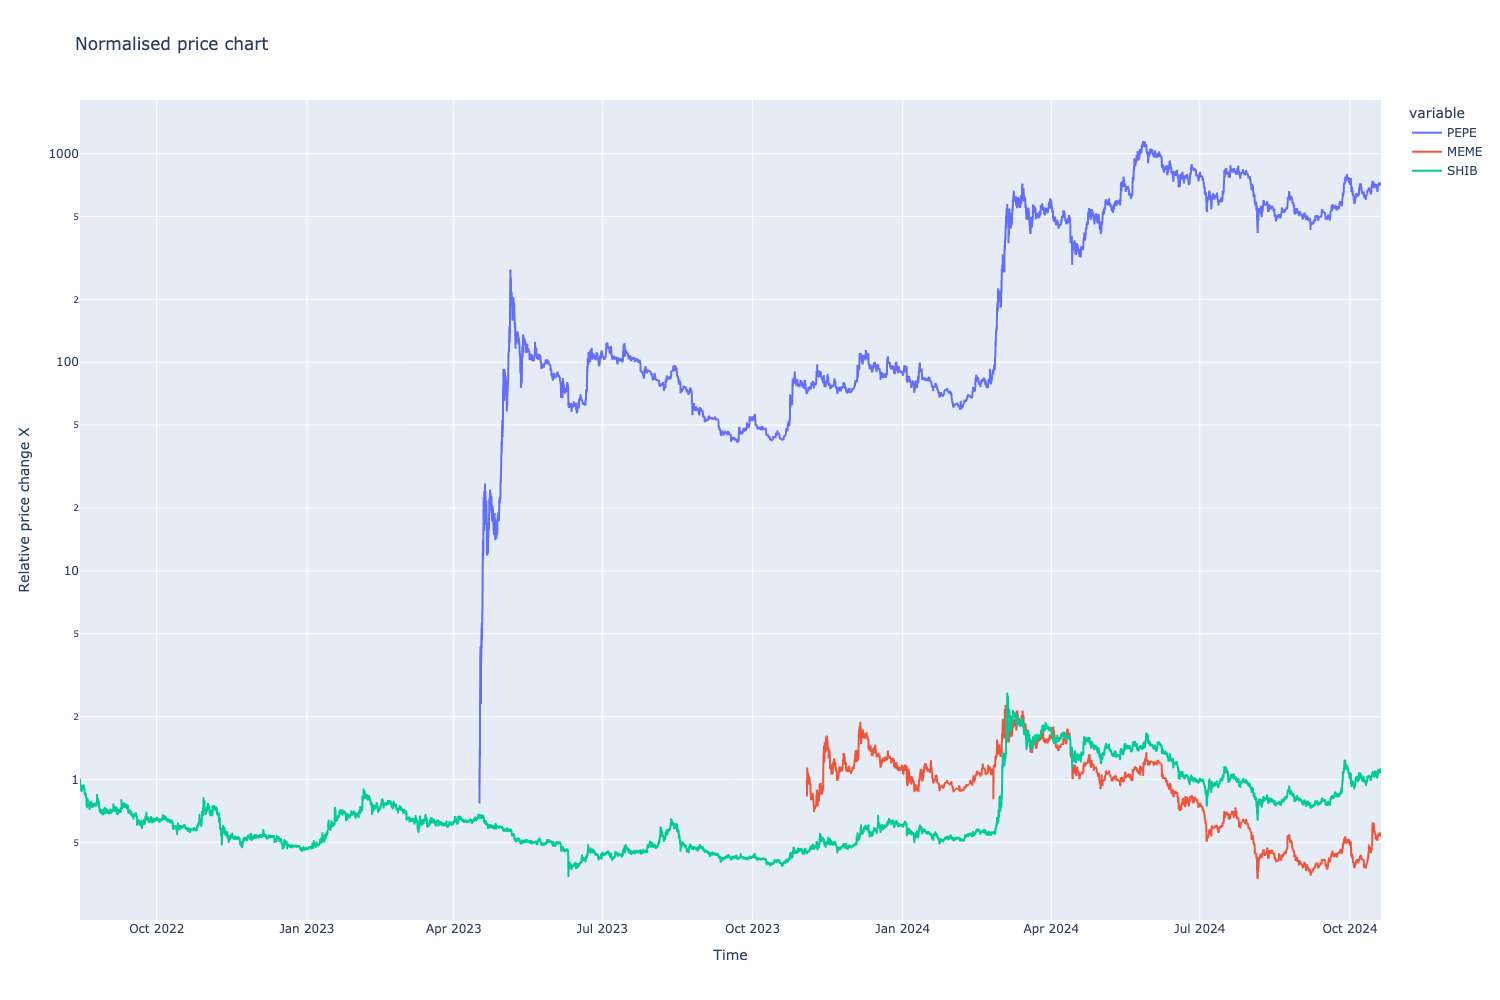

In [7]:
# Plot prices
# Problematic pair MEME-WETH #3376429 0x70cf99553471fe6c0d513ebfac8acc55ba02ab7b
import plotly.express as px
data = {}
for symbol in selected_assets:
    pair = token_map[symbol]
    candles = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)
    assert candles is not None, f"No candles found for asset {symbol}, we have token map for {list(token_map.keys())}, pair is #{pair.internal_id}, {pair}"
    price = candles["close"]
    first_price = price.iloc[0]
    data[symbol] = price / first_price
        

df = pd.DataFrame(data)
fig = px.line(df, title=f"Normalised price chart")
fig.update_layout(showlegend=True)
fig.update_yaxes(title=f"Relative price change X", type="log")
fig.update_xaxes(title="Time")
fig.show()

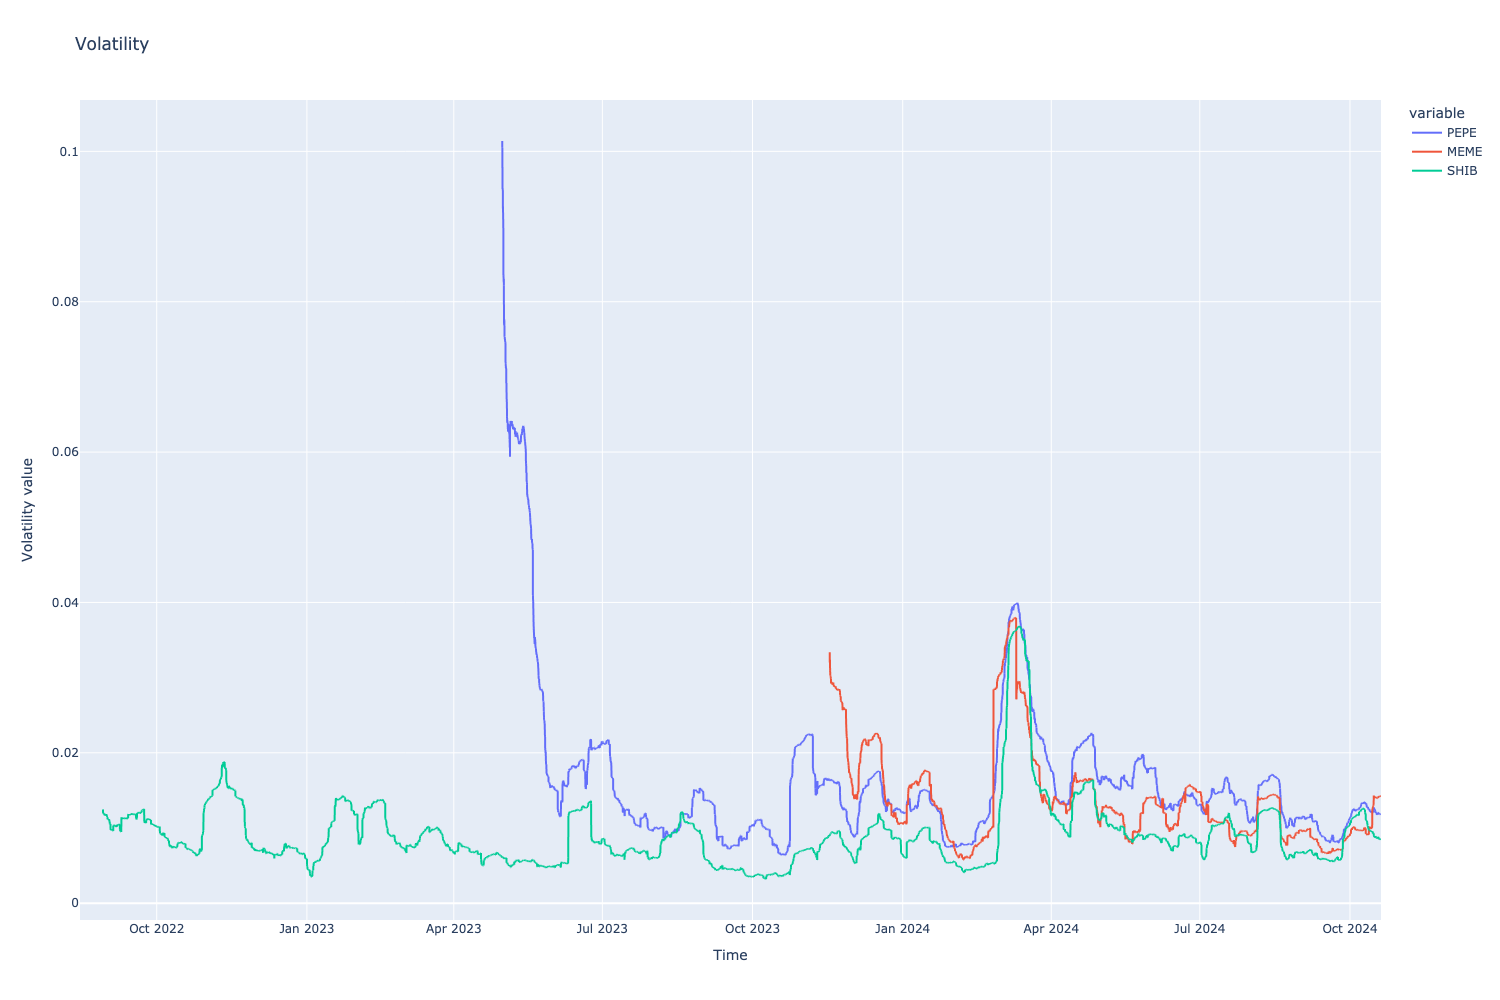

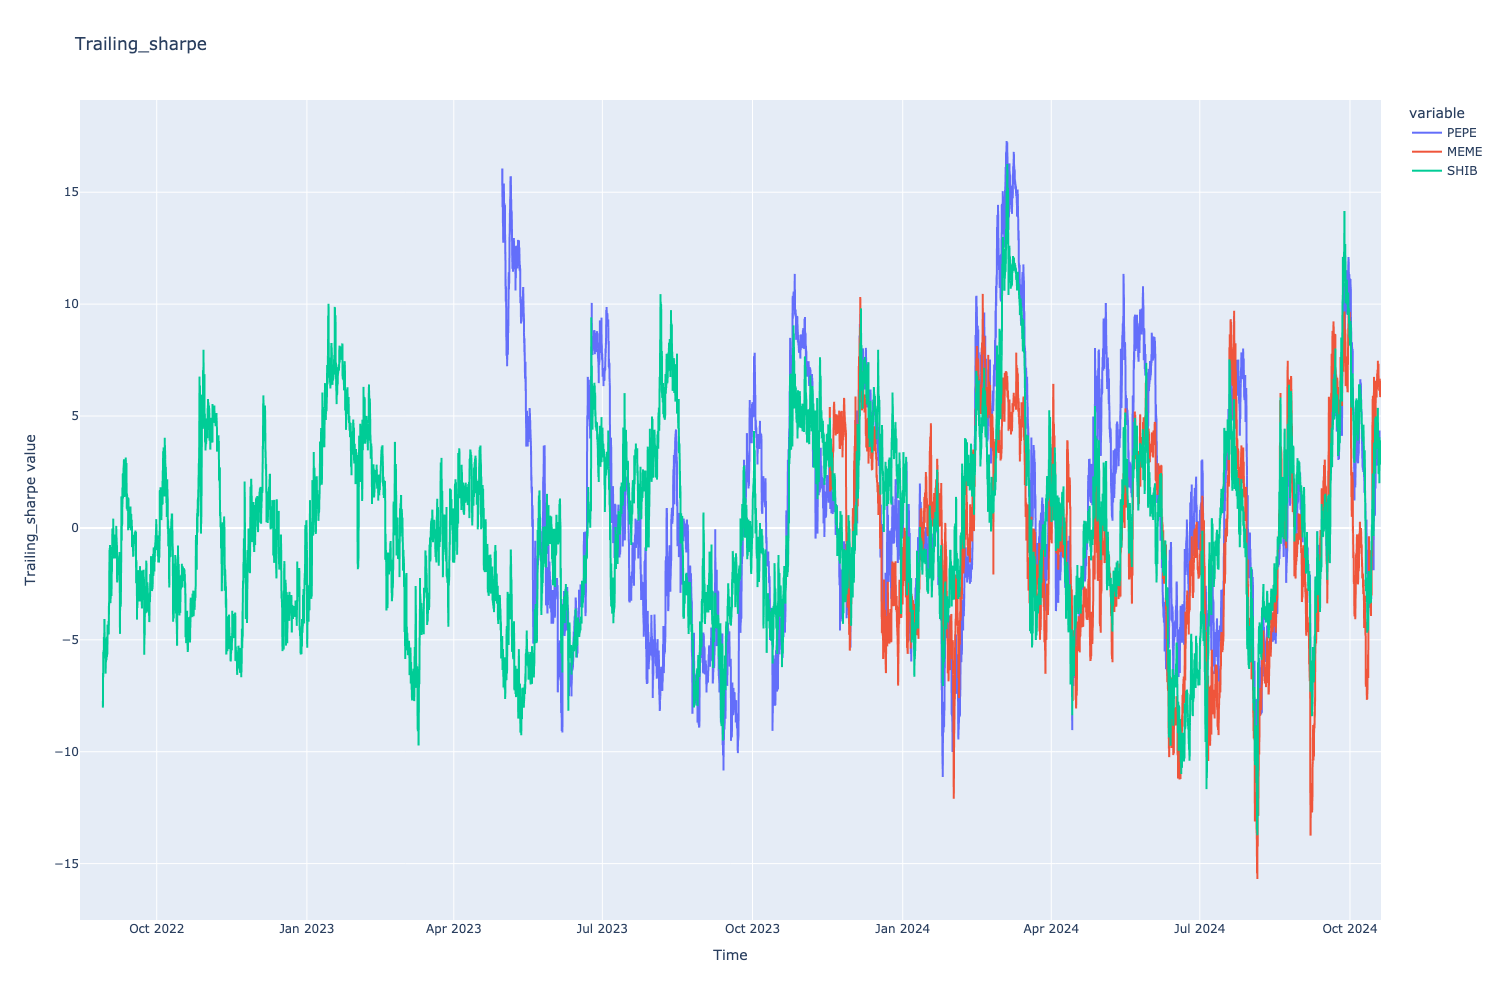

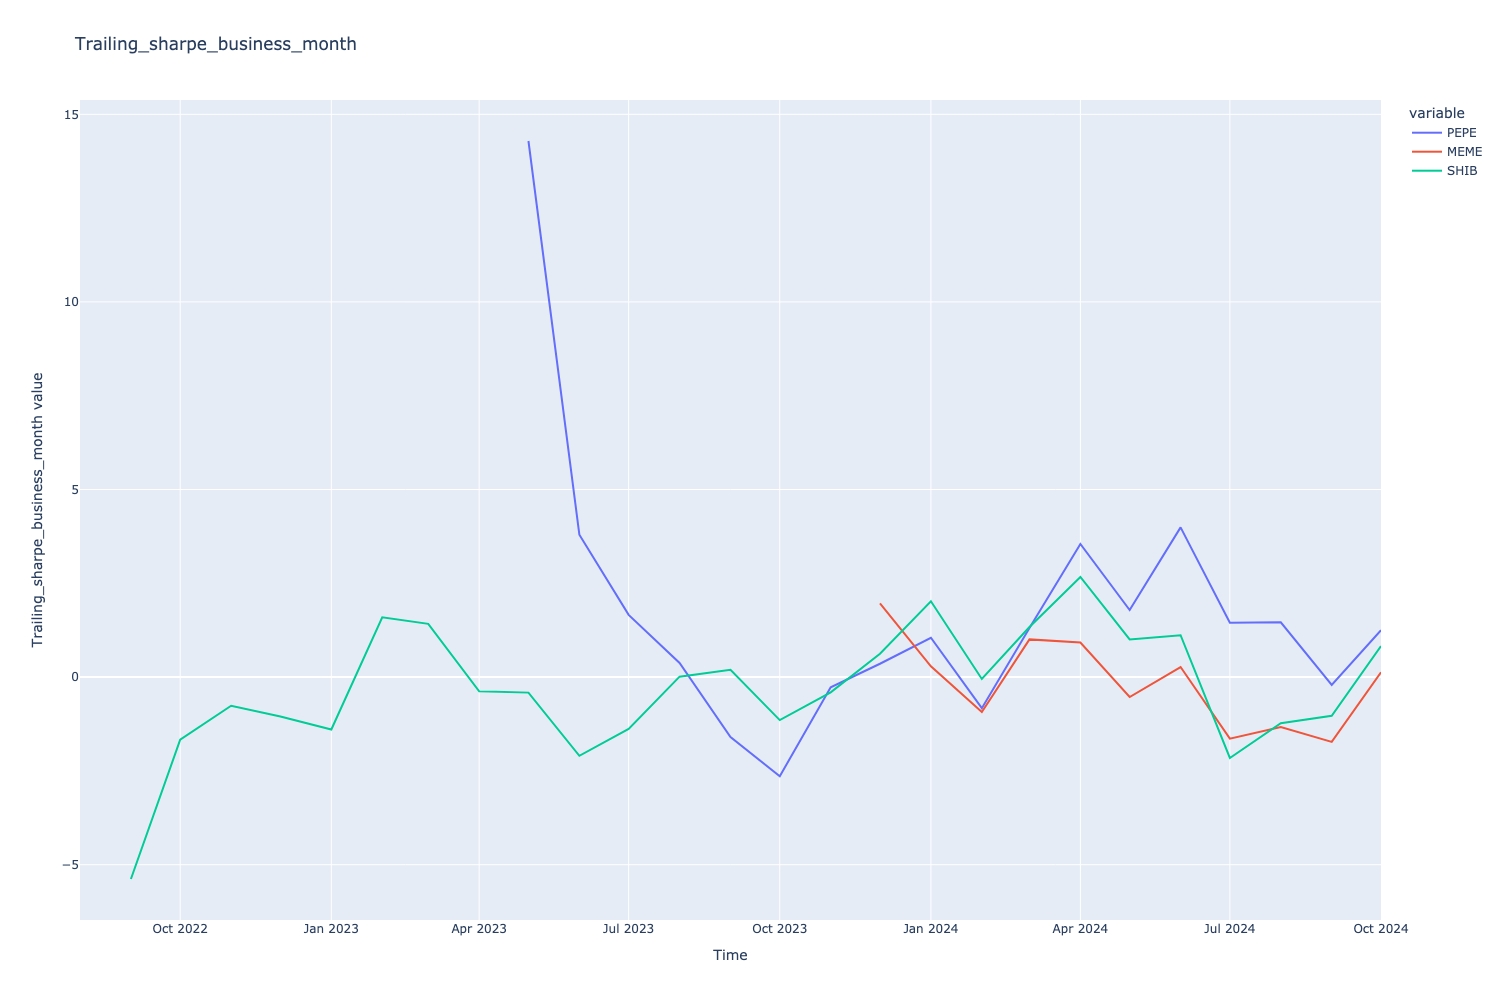

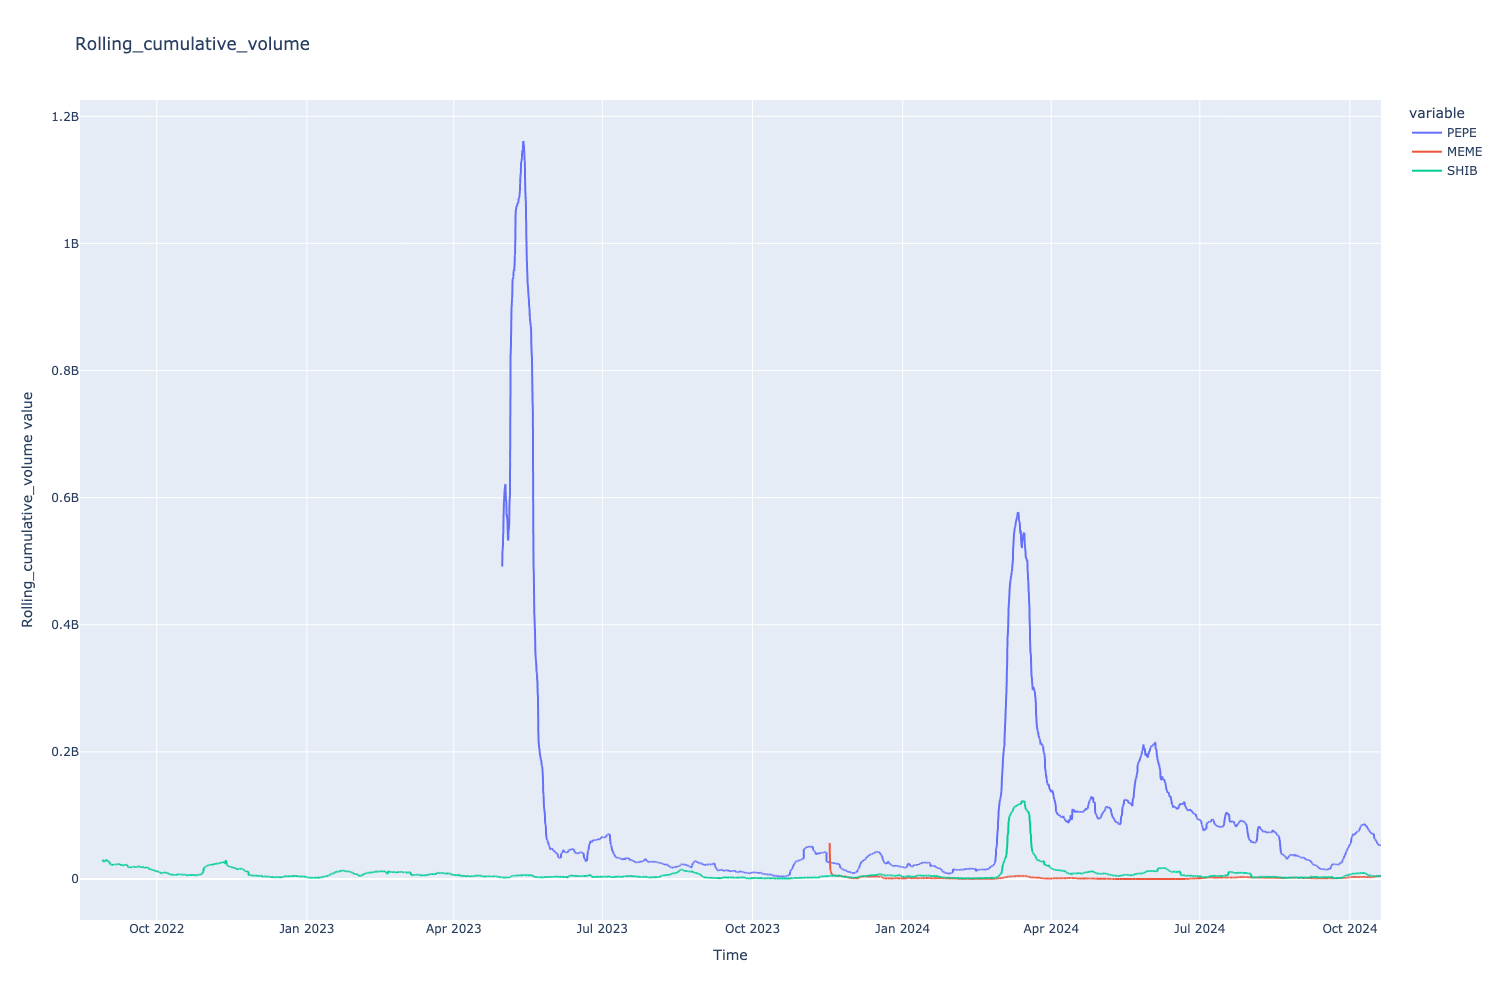

In [8]:
# Plot example indicators

import plotly.express as px

checked_indicators = [
    "volatility", 
    "trailing_sharpe", 
    "trailing_sharpe_business_month", 
    "rolling_cumulative_volume", 
    # "rolling_liquidity_avg"
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# Asset correlation

Asset KISHU lacks OHLCV data


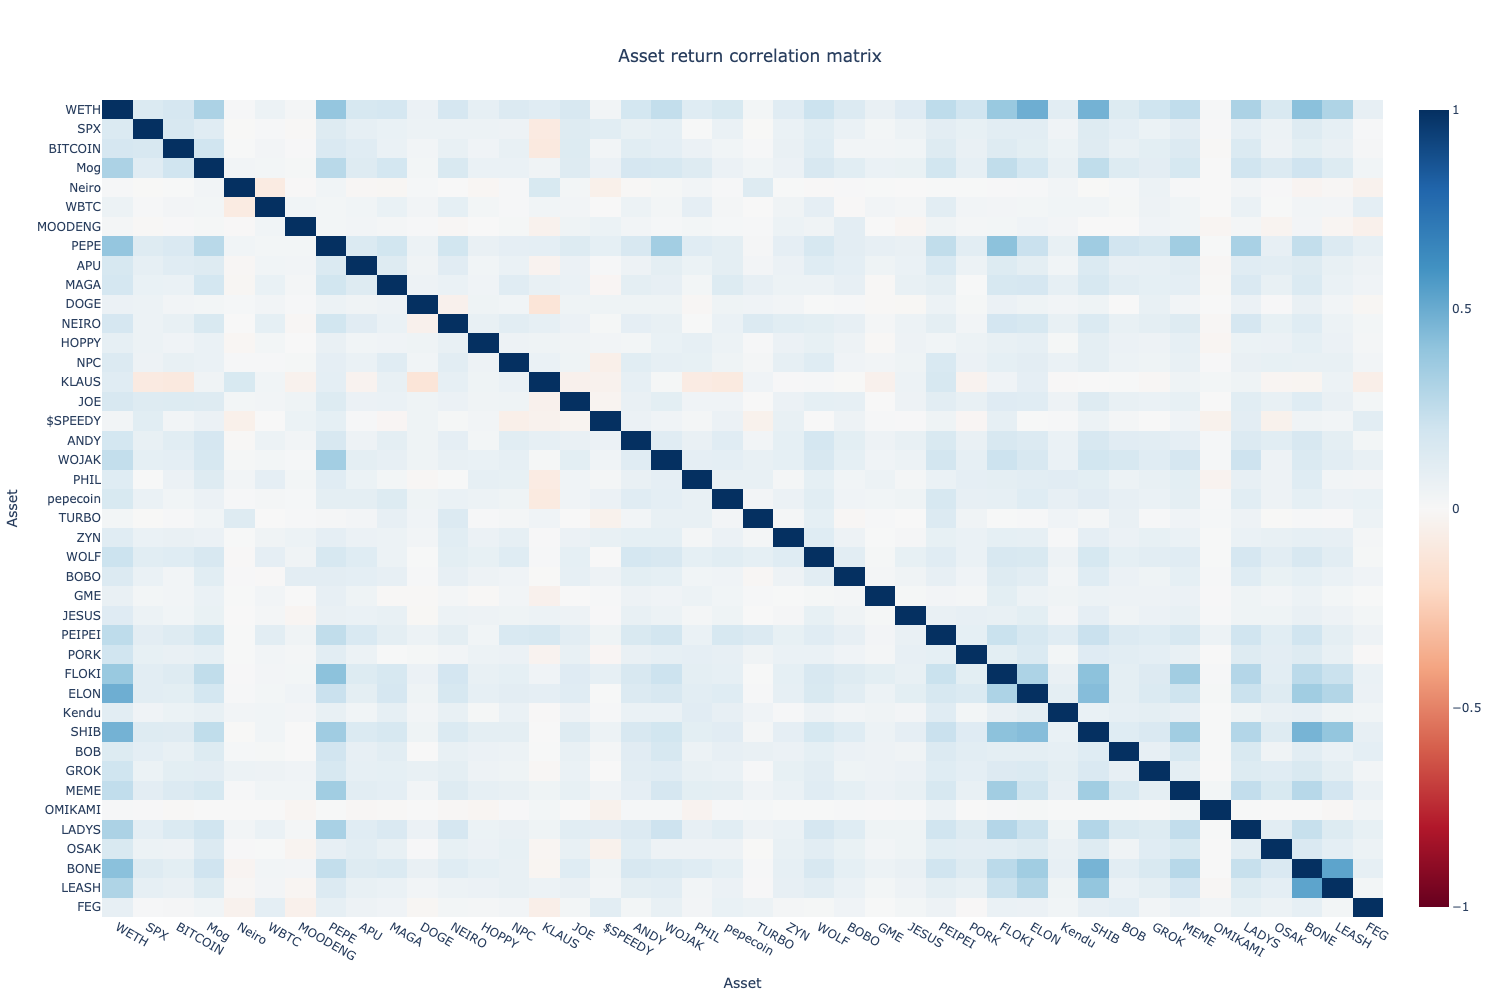

In [9]:
from tradeexecutor.visual.asset_correlation import visualise_asset_correlation

fig = visualise_asset_correlation(
    strategy_universe,
)

fig.show()

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [10]:
series = indicators.get_indicator_series("available_pairs")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-05-01 00:00:00 - 2024-10-01 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [11]:
from tradingstrategy.types import PrimaryKey

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh


#: Cache for monthly traded pairs
_monthly_cached_pairs: dict[pd.Timestamp, list[PrimaryKey]] = {}


def get_monthly_traded_pairs(
    timestamp: pd.Timestamp,
    monthly_traded_pairs: pd.Series,
) -> list[PrimaryKey]:
    # Speeded up version to get pairs we trade each month
    month_start = timestamp.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    if month_start not in _monthly_cached_pairs:        
        pair_ids = monthly_traded_pairs.xs(month_start, level='timestamp').index.unique()
        _monthly_cached_pairs[month_start]  = list(pair_ids)

    return _monthly_cached_pairs[month_start]


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Resolve pairs we have in the currently tradeable set
    monthly_traded_pairs = indicators.get_indicator_series(
        "monthly_traded_pairs",
        unlimited=True,
    )
    pair_ids = get_monthly_traded_pairs(timestamp, monthly_traded_pairs)

    if len(pair_ids) > parameters.min_asset_universe:
        state.mark_ready(timestamp)

    # Build signals for each pair 
    alpha_model = AlphaModel(timestamp)
    for pair_id in pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)

        volatility = indicators.get_indicator_value("volatility", pair=pair)
        if volatility is None:
            # Back buffer has not filled up yet with enough data,
            # skip to the next pair
            continue

        if volatility >= parameters.min_volatility_threshold:
            # Include this pair for the ranking for each tick
            alpha_model.set_signal(
                pair,
                volatility,
            )

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
            
    #
    # Do 1/N weighting
    #
    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=250_000,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=Parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    assert rebalance_threshold_usd > 150.00, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    if input.is_visualisation_enabled():
        # Save alpha model debug data to diagnose the strategy
        # (Only when not grid search/optimiser)
        # SLOW
        # state.visualisation.add_calculations(timestamp, alpha_model.to_dict())
        pass

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, volatility, rolling_cumulative_volume, trailing_sharpe_business_mon…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_43_2022-08-15-2024-10-20_ff


  0%|          | 0/44841600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 321 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time

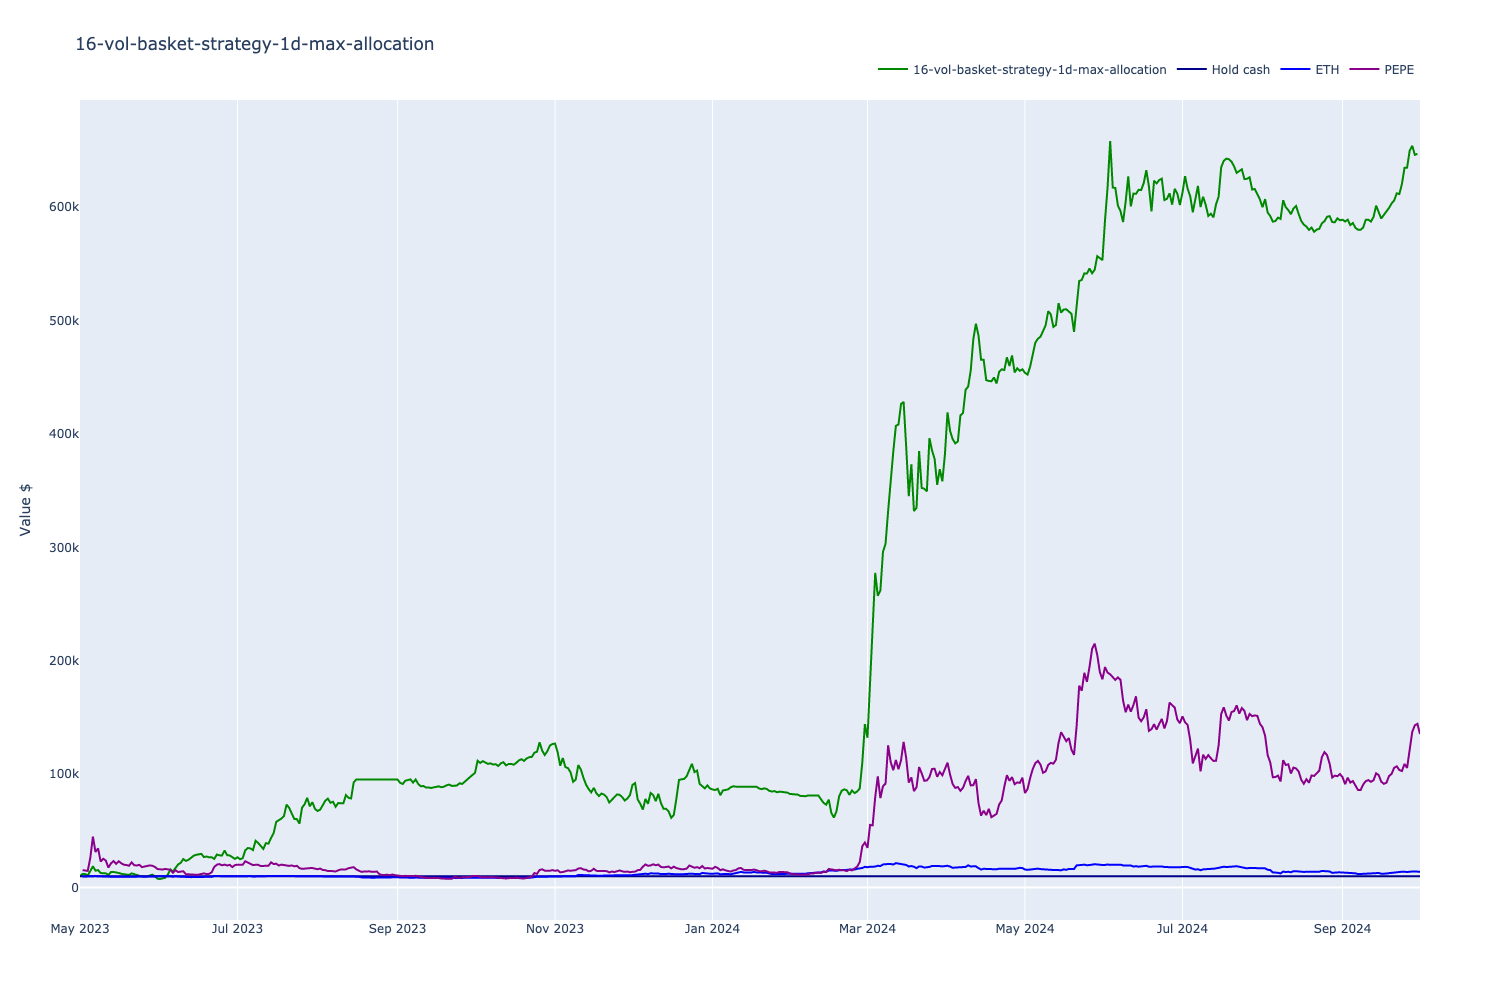

In [12]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "PEPE"]
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=False,
)

fig.show()

## Equity curve with drawdown

- Linear curve

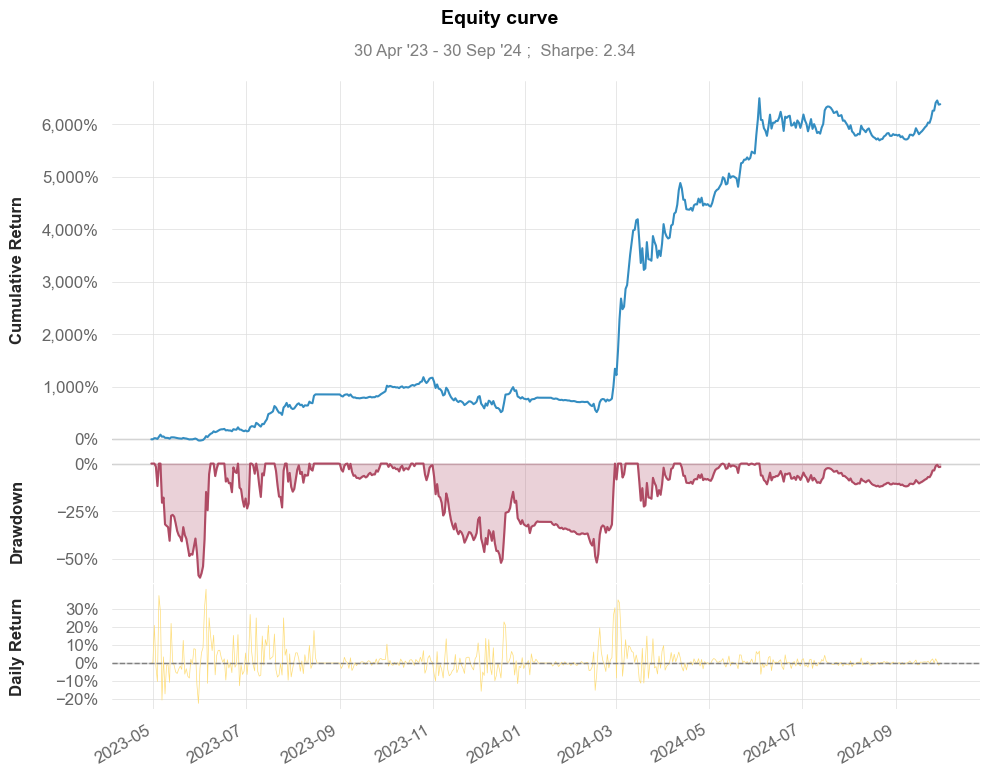

In [13]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

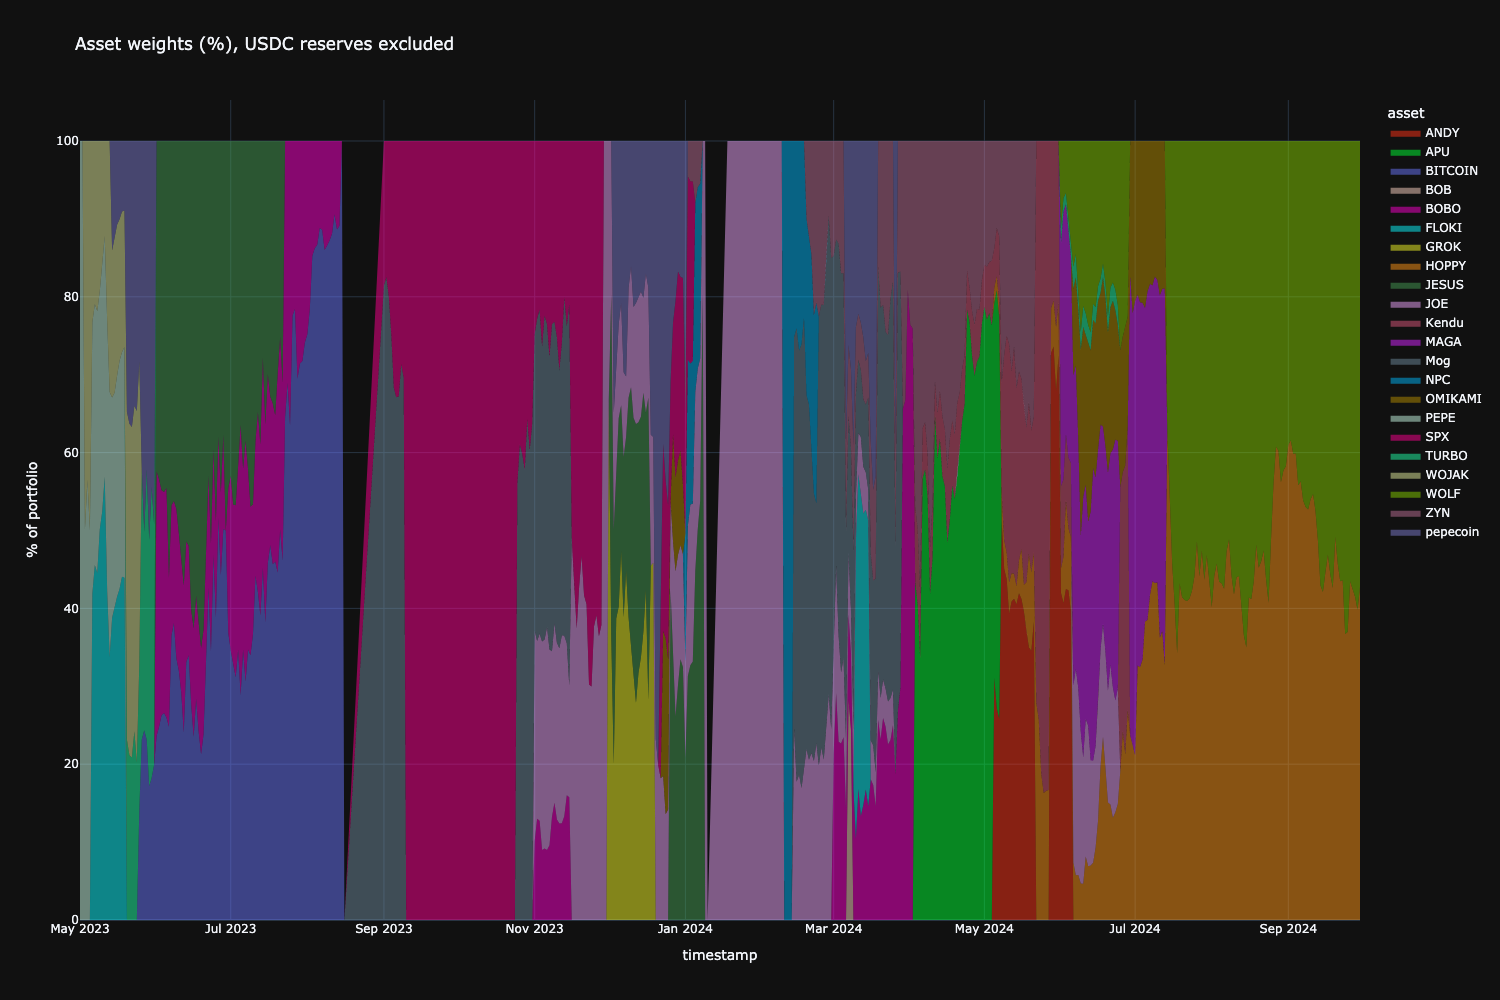

In [14]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

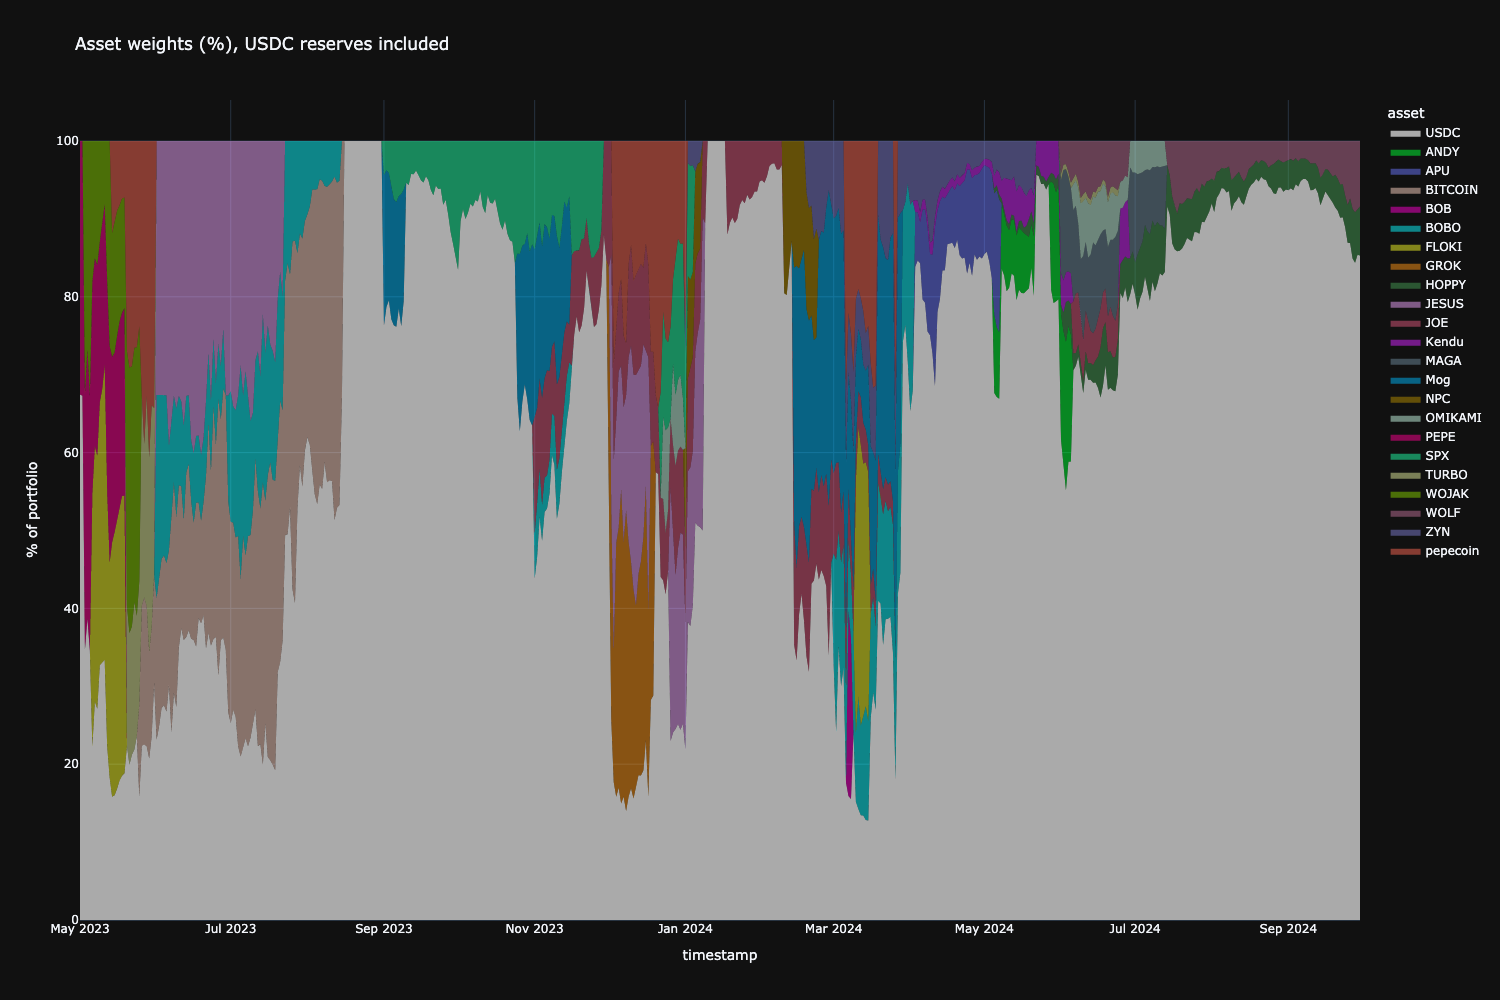

In [20]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

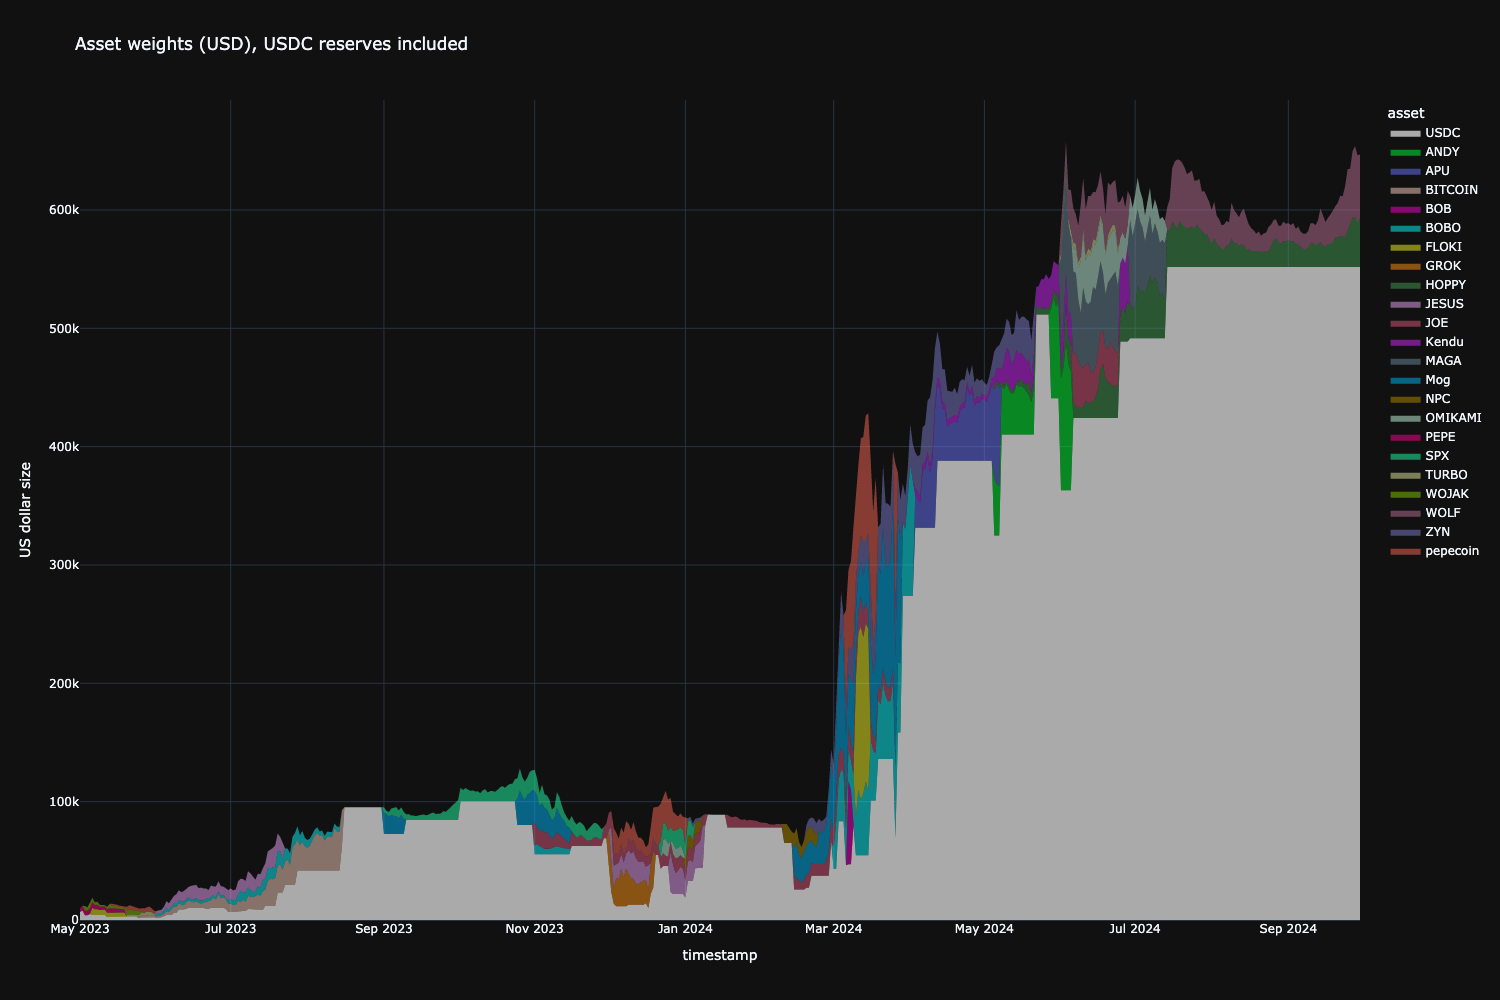

In [15]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [16]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At      Pair       Value Unit
Name                                                                          
Max position (excluding USDC)   2024-03-12 00:00:00     FLOKI  145,773.40  USD
Min position (excluding USDC)   2023-05-19 00:00:00  pepecoin      834.54  USD
Mean position (excluding USDC)                                  22,222.51  USD
Max position (excluding USDC)   2023-05-01 00:00:00      PEPE      100.00    %
Min position (excluding USDC)   2024-06-03 00:00:00     TURBO        1.44    %
Mean position (excluding USDC)                                      35.61    %
Max position (including USDC)   2023-08-16 00:00:00      USDC      100.00    %
Min position (including USDC)   2024-05-14 00:00:00     HOPPY        0.47    %
Mean position (including USDC)                                      27.19    %

# Trading pair breakdown

- Trade success for each trading pair



In [17]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [18]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

/Users/moo/code/trade-executor/tradeexecutor/analysis/multi_asset_benchmark.py:345: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Strategy                  BTC  \
Start Period                      2023-05-01           2023-05-01   
End Period                        2024-09-30           2024-09-30   
Risk-Free Rate                          0.0%                 0.0%   
Time in Market                         96.0%                98.0%   
Cumulative Return                  6,381.84%              123.17%   
CAGR﹪                                660.97%               47.78%   
Sharpe                                  2.82                 1.07   
Prob. Sharpe Ratio                    100.0%               91.99%   
Sortino                                 6.02                  1.9   
Sortino/√2                              4.26                 1.34   
Omega                                   1.72                 1.72   
Max Drawdown                         -59.74%              -40.76%   
Longest DD Days                          125                  200   
Gain/Pain Ratio                         0.72                 0.27   
Gain/Pain (1M)                         11.07                 3.23   
Payoff Ratio                            1.53                 1.11   
Profit Factor                           1.72                 1.27   
Common Sense Ratio                      3.51                 1.54   
CPC Index                               1.39                 0.71   
Tail Ratio                              2.05                 1.21   
Outlier Win Ratio                       6.71                 8.97   
Outlier Loss Ratio                      3.91                  5.0   
MTD                                    9.95%               10.31%   
3M                                     5.71%                8.25%   
6M                                    75.41%               -7.29%   
YTD                                  640.64%               54.25%   
1Y                                   564.34%              141.85%   
3Y (ann.)                            660.97%               47.78%   
5Y (ann.)                            660.97%               47.78%   
10Y (ann.)                           660.97%               47.78%   
All-time (ann.)                      660.97%               47.78%   
Avg. Drawdown                         -12.8%               -8.56%   
Avg. Drawdown Days                        17                   21   
Recovery Factor                         8.96                 3.06   
Ulcer Index                              0.2                 0.11   
Serenity Index                          4.94                  2.5   
Annualised return (raw)             6.609685                  NaN   
Benchmark start          2023-05-01 00:00:00  2023-05-01 00:00:00   
Start price                                -             29266.13   
End price                                  -             68243.94   
Price diff                                 -                 1.33   
Multiplier X                               -                 2.33   
Candle freq                                -      0 days 01:00:00   

                                         ETH  
Start Period                      2023-05-01  
End Period                        2024-09-30  
Risk-Free Rate                          0.0%  
Time in Market                        100.0%  
Cumulative Return                     40.49%  
CAGR﹪                                 17.99%  
Sharpe                                  0.71  
Prob. Sharpe Ratio                     80.3%  
Sortino                                 1.09  
Sortino/√2                              0.77  
Omega                                   1.72  
Max Drawdown                         -44.97%  
Longest DD Days                          202  
Gain/Pain Ratio                         0.11  
Gain/Pain (1M)                          1.03  
Payoff Ratio                            1.03  
Profit Factor                           1.11  
Common Sense Ratio                      1.22  
CPC Index                               0.57  
Tail Ratio                              1.09  
Outlier Win 

# Trading metrics

- Trading cost, etc.

In [19]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())